<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[10:09:47] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


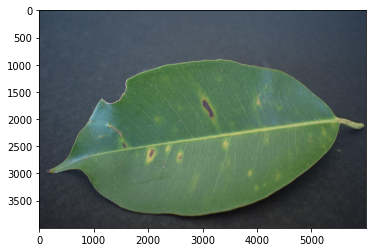

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

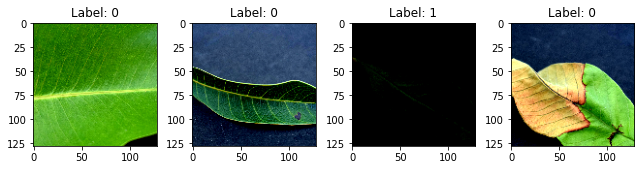

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[10:09:55] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[10:09:57] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2604650610675703 samples/sec                   batch loss = 0.8527363538742065 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.2613662848658744 samples/sec                   batch loss = 0.428272008895874 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2686739642900515 samples/sec                   batch loss = 1.0739401578903198 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2678879708400856 samples/sec                   batch loss = 1.2669172286987305 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.2583880644212588 samples/sec                   batch loss = 0.9841352105140686 | accuracy = 0.52


Epoch[1] Batch[30] Speed: 1.2684667770622546 samples/sec                   batch loss = 0.7316210865974426 | accuracy = 0.5083333333333333


Epoch[1] Batch[35] Speed: 1.2681530556448752 samples/sec                   batch loss = 0.7683448791503906 | accuracy = 0.5


Epoch[1] Batch[40] Speed: 1.268055480813359 samples/sec                   batch loss = 0.5580277442932129 | accuracy = 0.50625


Epoch[1] Batch[45] Speed: 1.270210025240339 samples/sec                   batch loss = 0.41214829683303833 | accuracy = 0.5222222222222223


Epoch[1] Batch[50] Speed: 1.2650724310055406 samples/sec                   batch loss = 0.512711226940155 | accuracy = 0.54


Epoch[1] Batch[55] Speed: 1.270842741882338 samples/sec                   batch loss = 0.4977087676525116 | accuracy = 0.55


Epoch[1] Batch[60] Speed: 1.2727514381898501 samples/sec                   batch loss = 0.7587258815765381 | accuracy = 0.5625


Epoch[1] Batch[65] Speed: 1.2662815314344664 samples/sec                   batch loss = 0.34647393226623535 | accuracy = 0.5692307692307692


Epoch[1] Batch[70] Speed: 1.2675520301990364 samples/sec                   batch loss = 0.741794228553772 | accuracy = 0.5785714285714286


Epoch[1] Batch[75] Speed: 1.2638630667159239 samples/sec                   batch loss = 0.3745918869972229 | accuracy = 0.5866666666666667


Epoch[1] Batch[80] Speed: 1.2639563788858041 samples/sec                   batch loss = 0.391012579202652 | accuracy = 0.590625


Epoch[1] Batch[85] Speed: 1.2667574786014217 samples/sec                   batch loss = 0.3869199752807617 | accuracy = 0.5970588235294118


Epoch[1] Batch[90] Speed: 1.2663131672834238 samples/sec                   batch loss = 0.511338472366333 | accuracy = 0.5888888888888889


Epoch[1] Batch[95] Speed: 1.2664047385587613 samples/sec                   batch loss = 0.8428062200546265 | accuracy = 0.5921052631578947


Epoch[1] Batch[100] Speed: 1.2681252577487903 samples/sec                   batch loss = 0.6965576410293579 | accuracy = 0.59


Epoch[1] Batch[105] Speed: 1.2669170363146744 samples/sec                   batch loss = 0.8754943013191223 | accuracy = 0.5952380952380952


Epoch[1] Batch[110] Speed: 1.2644658395878756 samples/sec                   batch loss = 0.6859022378921509 | accuracy = 0.6


Epoch[1] Batch[115] Speed: 1.2684890272613132 samples/sec                   batch loss = 1.440314531326294 | accuracy = 0.5934782608695652


Epoch[1] Batch[120] Speed: 1.2671850650978962 samples/sec                   batch loss = 0.6878476142883301 | accuracy = 0.59375


Epoch[1] Batch[125] Speed: 1.2627544688077244 samples/sec                   batch loss = 1.0252606868743896 | accuracy = 0.592


Epoch[1] Batch[130] Speed: 1.2679122129653975 samples/sec                   batch loss = 0.5001399517059326 | accuracy = 0.6


Epoch[1] Batch[135] Speed: 1.2741715826864966 samples/sec                   batch loss = 0.42046481370925903 | accuracy = 0.6037037037037037


Epoch[1] Batch[140] Speed: 1.2696842994133888 samples/sec                   batch loss = 0.4269144535064697 | accuracy = 0.6053571428571428


Epoch[1] Batch[145] Speed: 1.268738148507076 samples/sec                   batch loss = 0.9498405456542969 | accuracy = 0.6086206896551725


Epoch[1] Batch[150] Speed: 1.2674130888537527 samples/sec                   batch loss = 0.4503844380378723 | accuracy = 0.6116666666666667


Epoch[1] Batch[155] Speed: 1.2670105129480056 samples/sec                   batch loss = 0.7446912527084351 | accuracy = 0.614516129032258


Epoch[1] Batch[160] Speed: 1.2642916546220015 samples/sec                   batch loss = 1.3670799732208252 | accuracy = 0.6171875


Epoch[1] Batch[165] Speed: 1.2658549364160734 samples/sec                   batch loss = 0.47283798456192017 | accuracy = 0.6227272727272727


Epoch[1] Batch[170] Speed: 1.2741515518331195 samples/sec                   batch loss = 0.3297150731086731 | accuracy = 0.625


Epoch[1] Batch[175] Speed: 1.2681833471536352 samples/sec                   batch loss = 0.44438081979751587 | accuracy = 0.6257142857142857


Epoch[1] Batch[180] Speed: 1.2664848503880706 samples/sec                   batch loss = 0.48200052976608276 | accuracy = 0.6291666666666667


Epoch[1] Batch[185] Speed: 1.2721613847537625 samples/sec                   batch loss = 0.6424303650856018 | accuracy = 0.6324324324324324


Epoch[1] Batch[190] Speed: 1.2644220029657802 samples/sec                   batch loss = 0.3780018985271454 | accuracy = 0.6328947368421053


Epoch[1] Batch[195] Speed: 1.2641543796165209 samples/sec                   batch loss = 0.7668673992156982 | accuracy = 0.6384615384615384


Epoch[1] Batch[200] Speed: 1.2679395223987169 samples/sec                   batch loss = 0.41307371854782104 | accuracy = 0.63875


Epoch[1] Batch[205] Speed: 1.2710487801588939 samples/sec                   batch loss = 0.20621035993099213 | accuracy = 0.6414634146341464


Epoch[1] Batch[210] Speed: 1.2816623122641366 samples/sec                   batch loss = 0.5851861238479614 | accuracy = 0.6428571428571429


Epoch[1] Batch[215] Speed: 1.2766366926853092 samples/sec                   batch loss = 0.20436406135559082 | accuracy = 0.6430232558139535


Epoch[1] Batch[220] Speed: 1.2764768141399276 samples/sec                   batch loss = 0.573965847492218 | accuracy = 0.6454545454545455


Epoch[1] Batch[225] Speed: 1.2742481315078231 samples/sec                   batch loss = 0.448661744594574 | accuracy = 0.6488888888888888


Epoch[1] Batch[230] Speed: 1.2694530564165005 samples/sec                   batch loss = 0.49472054839134216 | accuracy = 0.6510869565217391


Epoch[1] Batch[235] Speed: 1.2786930350806445 samples/sec                   batch loss = 0.5919304490089417 | accuracy = 0.6510638297872341


Epoch[1] Batch[240] Speed: 1.2775984595606495 samples/sec                   batch loss = 0.6600330471992493 | accuracy = 0.65


Epoch[1] Batch[245] Speed: 1.2794992194369728 samples/sec                   batch loss = 0.45639562606811523 | accuracy = 0.6551020408163265


Epoch[1] Batch[250] Speed: 1.2754852190598844 samples/sec                   batch loss = 0.6586786508560181 | accuracy = 0.656


Epoch[1] Batch[255] Speed: 1.2687431376868425 samples/sec                   batch loss = 0.626201331615448 | accuracy = 0.6558823529411765


Epoch[1] Batch[260] Speed: 1.2694901341675726 samples/sec                   batch loss = 0.4765729010105133 | accuracy = 0.6596153846153846


Epoch[1] Batch[265] Speed: 1.2628797472737445 samples/sec                   batch loss = 0.6970716118812561 | accuracy = 0.6613207547169812


Epoch[1] Batch[270] Speed: 1.2630137029614004 samples/sec                   batch loss = 0.3511420786380768 | accuracy = 0.6638888888888889


Epoch[1] Batch[275] Speed: 1.2662856411381977 samples/sec                   batch loss = 0.8339422941207886 | accuracy = 0.6663636363636364


Epoch[1] Batch[280] Speed: 1.2630731317230468 samples/sec                   batch loss = 0.42281198501586914 | accuracy = 0.66875


Epoch[1] Batch[285] Speed: 1.2711112788023993 samples/sec                   batch loss = 0.7359956502914429 | accuracy = 0.6649122807017543


Epoch[1] Batch[290] Speed: 1.278351637190235 samples/sec                   batch loss = 0.5043830871582031 | accuracy = 0.6663793103448276


Epoch[1] Batch[295] Speed: 1.2685613457994578 samples/sec                   batch loss = 0.5524278283119202 | accuracy = 0.6652542372881356


Epoch[1] Batch[300] Speed: 1.2700272359311113 samples/sec                   batch loss = 0.6273972392082214 | accuracy = 0.6675


Epoch[1] Batch[305] Speed: 1.2724180303189112 samples/sec                   batch loss = 0.4728944003582001 | accuracy = 0.6680327868852459


Epoch[1] Batch[310] Speed: 1.2663172771925058 samples/sec                   batch loss = 0.44631943106651306 | accuracy = 0.667741935483871


Epoch[1] Batch[315] Speed: 1.269475533343866 samples/sec                   batch loss = 0.7248108983039856 | accuracy = 0.6698412698412698


Epoch[1] Batch[320] Speed: 1.2689105858015144 samples/sec                   batch loss = 0.4068247675895691 | accuracy = 0.67109375


Epoch[1] Batch[325] Speed: 1.2720300145784575 samples/sec                   batch loss = 0.6194548010826111 | accuracy = 0.6715384615384615


Epoch[1] Batch[330] Speed: 1.2639126727969823 samples/sec                   batch loss = 0.6337025761604309 | accuracy = 0.671969696969697


Epoch[1] Batch[335] Speed: 1.2669098610940366 samples/sec                   batch loss = 0.6111414432525635 | accuracy = 0.673134328358209


Epoch[1] Batch[340] Speed: 1.2665301687270951 samples/sec                   batch loss = 0.6639152765274048 | accuracy = 0.6735294117647059


Epoch[1] Batch[345] Speed: 1.2732150630399162 samples/sec                   batch loss = 0.38227277994155884 | accuracy = 0.6731884057971015


Epoch[1] Batch[350] Speed: 1.2627767091485667 samples/sec                   batch loss = 1.5764796733856201 | accuracy = 0.6721428571428572


Epoch[1] Batch[355] Speed: 1.265339011761611 samples/sec                   batch loss = 0.4715103209018707 | accuracy = 0.6725352112676056


Epoch[1] Batch[360] Speed: 1.2626984912463841 samples/sec                   batch loss = 0.34580039978027344 | accuracy = 0.6756944444444445


Epoch[1] Batch[365] Speed: 1.2647248235593258 samples/sec                   batch loss = 1.2510664463043213 | accuracy = 0.6760273972602739


Epoch[1] Batch[370] Speed: 1.2746990948818417 samples/sec                   batch loss = 0.31594565510749817 | accuracy = 0.6783783783783783


Epoch[1] Batch[375] Speed: 1.2710951961296533 samples/sec                   batch loss = 0.5834404230117798 | accuracy = 0.678


Epoch[1] Batch[380] Speed: 1.2683963871770005 samples/sec                   batch loss = 0.36403200030326843 | accuracy = 0.6756578947368421


Epoch[1] Batch[385] Speed: 1.2704937846036037 samples/sec                   batch loss = 0.44256553053855896 | accuracy = 0.6753246753246753


Epoch[1] Batch[390] Speed: 1.2809363289617754 samples/sec                   batch loss = 0.2863517701625824 | accuracy = 0.6756410256410257


Epoch[1] Batch[395] Speed: 1.2746807906702804 samples/sec                   batch loss = 0.6412386894226074 | accuracy = 0.6765822784810127


Epoch[1] Batch[400] Speed: 1.2705799956014583 samples/sec                   batch loss = 0.7095003128051758 | accuracy = 0.6775


Epoch[1] Batch[405] Speed: 1.269204614528601 samples/sec                   batch loss = 0.3358796238899231 | accuracy = 0.6796296296296296


Epoch[1] Batch[410] Speed: 1.2692683723229068 samples/sec                   batch loss = 0.30392149090766907 | accuracy = 0.6823170731707318


Epoch[1] Batch[415] Speed: 1.2698263341652152 samples/sec                   batch loss = 0.2240159958600998 | accuracy = 0.6825301204819277


Epoch[1] Batch[420] Speed: 1.2724155212521069 samples/sec                   batch loss = 0.3667771518230438 | accuracy = 0.6821428571428572


Epoch[1] Batch[425] Speed: 1.2728524409971411 samples/sec                   batch loss = 0.4696696102619171 | accuracy = 0.6829411764705883


Epoch[1] Batch[430] Speed: 1.2697533908344012 samples/sec                   batch loss = 0.3488548994064331 | accuracy = 0.6831395348837209


Epoch[1] Batch[435] Speed: 1.2634810114284931 samples/sec                   batch loss = 1.1576358079910278 | accuracy = 0.6821839080459771


Epoch[1] Batch[440] Speed: 1.259502148340522 samples/sec                   batch loss = 0.8776258230209351 | accuracy = 0.6835227272727272


Epoch[1] Batch[445] Speed: 1.259808198041672 samples/sec                   batch loss = 0.5110724568367004 | accuracy = 0.6837078651685393


Epoch[1] Batch[450] Speed: 1.2627898256142596 samples/sec                   batch loss = 0.39237692952156067 | accuracy = 0.6838888888888889


Epoch[1] Batch[455] Speed: 1.2630946225400577 samples/sec                   batch loss = 0.9551770091056824 | accuracy = 0.6840659340659341


Epoch[1] Batch[460] Speed: 1.263119632685896 samples/sec                   batch loss = 0.4274060130119324 | accuracy = 0.6847826086956522


Epoch[1] Batch[465] Speed: 1.2588514833239404 samples/sec                   batch loss = 0.49242621660232544 | accuracy = 0.6849462365591398


Epoch[1] Batch[470] Speed: 1.2624780506452085 samples/sec                   batch loss = 0.934436559677124 | accuracy = 0.6835106382978723


Epoch[1] Batch[475] Speed: 1.2603686656716266 samples/sec                   batch loss = 0.5141226649284363 | accuracy = 0.6815789473684211


Epoch[1] Batch[480] Speed: 1.2581540297569058 samples/sec                   batch loss = 0.06699074804782867 | accuracy = 0.6828125


Epoch[1] Batch[485] Speed: 1.261122799020641 samples/sec                   batch loss = 0.3580375909805298 | accuracy = 0.6829896907216495


Epoch[1] Batch[490] Speed: 1.2614724126670742 samples/sec                   batch loss = 0.5612644553184509 | accuracy = 0.6826530612244898


Epoch[1] Batch[495] Speed: 1.264261358198754 samples/sec                   batch loss = 0.9029479622840881 | accuracy = 0.6833333333333333


Epoch[1] Batch[500] Speed: 1.2591139365239732 samples/sec                   batch loss = 0.4615858495235443 | accuracy = 0.683


Epoch[1] Batch[505] Speed: 1.263602056262368 samples/sec                   batch loss = 0.4383088946342468 | accuracy = 0.6851485148514852


Epoch[1] Batch[510] Speed: 1.2626818604994217 samples/sec                   batch loss = 0.5081480741500854 | accuracy = 0.6857843137254902


Epoch[1] Batch[515] Speed: 1.2641277092367387 samples/sec                   batch loss = 0.4291975200176239 | accuracy = 0.6849514563106797


Epoch[1] Batch[520] Speed: 1.265193399330377 samples/sec                   batch loss = 0.30429404973983765 | accuracy = 0.6855769230769231


Epoch[1] Batch[525] Speed: 1.262287982438796 samples/sec                   batch loss = 0.6436577439308167 | accuracy = 0.6861904761904762


Epoch[1] Batch[530] Speed: 1.268380277239244 samples/sec                   batch loss = 0.559975802898407 | accuracy = 0.6867924528301886


Epoch[1] Batch[535] Speed: 1.2704928224933023 samples/sec                   batch loss = 0.32711780071258545 | accuracy = 0.6878504672897197


Epoch[1] Batch[540] Speed: 1.2661253824570877 samples/sec                   batch loss = 0.31609490513801575 | accuracy = 0.6898148148148148


Epoch[1] Batch[545] Speed: 1.2670877348589042 samples/sec                   batch loss = 0.44438275694847107 | accuracy = 0.6889908256880733


Epoch[1] Batch[550] Speed: 1.269269812708513 samples/sec                   batch loss = 0.6551499962806702 | accuracy = 0.6886363636363636


Epoch[1] Batch[555] Speed: 1.2656450406620106 samples/sec                   batch loss = 1.1922261714935303 | accuracy = 0.6882882882882883


Epoch[1] Batch[560] Speed: 1.2764494270583253 samples/sec                   batch loss = 0.26739010214805603 | accuracy = 0.6888392857142858


Epoch[1] Batch[565] Speed: 1.277016832093668 samples/sec                   batch loss = 0.75189608335495 | accuracy = 0.6880530973451328


Epoch[1] Batch[570] Speed: 1.277143401100916 samples/sec                   batch loss = 0.6066769957542419 | accuracy = 0.6885964912280702


Epoch[1] Batch[575] Speed: 1.2725370293495886 samples/sec                   batch loss = 1.8575689792633057 | accuracy = 0.6878260869565217


Epoch[1] Batch[580] Speed: 1.273533324401433 samples/sec                   batch loss = 0.24106067419052124 | accuracy = 0.6883620689655172


Epoch[1] Batch[585] Speed: 1.2685821604877547 samples/sec                   batch loss = 0.4521781802177429 | accuracy = 0.688034188034188


Epoch[1] Batch[590] Speed: 1.267931760650637 samples/sec                   batch loss = 0.515466034412384 | accuracy = 0.6889830508474576


Epoch[1] Batch[595] Speed: 1.273761704627597 samples/sec                   batch loss = 0.29504674673080444 | accuracy = 0.6899159663865546


Epoch[1] Batch[600] Speed: 1.2721105503443193 samples/sec                   batch loss = 0.2926839590072632 | accuracy = 0.6904166666666667


Epoch[1] Batch[605] Speed: 1.2697230242767734 samples/sec                   batch loss = 0.25517481565475464 | accuracy = 0.6913223140495868


Epoch[1] Batch[610] Speed: 1.271830021351793 samples/sec                   batch loss = 0.49384555220603943 | accuracy = 0.6913934426229508


Epoch[1] Batch[615] Speed: 1.2728906833370688 samples/sec                   batch loss = 0.5241570472717285 | accuracy = 0.6910569105691057


Epoch[1] Batch[620] Speed: 1.2702388763349752 samples/sec                   batch loss = 0.9877437949180603 | accuracy = 0.6903225806451613


Epoch[1] Batch[625] Speed: 1.2674655593313864 samples/sec                   batch loss = 0.6938384771347046 | accuracy = 0.69


Epoch[1] Batch[630] Speed: 1.2641745736526866 samples/sec                   batch loss = 0.4513718783855438 | accuracy = 0.6900793650793651


Epoch[1] Batch[635] Speed: 1.269264531310606 samples/sec                   batch loss = 0.39485809206962585 | accuracy = 0.6893700787401574


Epoch[1] Batch[640] Speed: 1.2741152656591437 samples/sec                   batch loss = 0.33285635709762573 | accuracy = 0.689453125


Epoch[1] Batch[645] Speed: 1.27308859518679 samples/sec                   batch loss = 0.41027694940567017 | accuracy = 0.6883720930232559


Epoch[1] Batch[650] Speed: 1.2715511579970458 samples/sec                   batch loss = 0.6034629344940186 | accuracy = 0.6884615384615385


Epoch[1] Batch[655] Speed: 1.275440518118518 samples/sec                   batch loss = 1.2001824378967285 | accuracy = 0.6889312977099237


Epoch[1] Batch[660] Speed: 1.272697660252435 samples/sec                   batch loss = 0.3526548743247986 | accuracy = 0.6901515151515152


Epoch[1] Batch[665] Speed: 1.2746582258842776 samples/sec                   batch loss = 0.2533859610557556 | accuracy = 0.6909774436090226


Epoch[1] Batch[670] Speed: 1.2777165807200024 samples/sec                   batch loss = 1.0930540561676025 | accuracy = 0.6906716417910448


Epoch[1] Batch[675] Speed: 1.272512417018878 samples/sec                   batch loss = 0.7121812701225281 | accuracy = 0.6907407407407408


Epoch[1] Batch[680] Speed: 1.2737587067275338 samples/sec                   batch loss = 0.6508714556694031 | accuracy = 0.6904411764705882


Epoch[1] Batch[685] Speed: 1.2700172374025065 samples/sec                   batch loss = 0.27852723002433777 | accuracy = 0.6905109489051094


Epoch[1] Batch[690] Speed: 1.273872540127759 samples/sec                   batch loss = 0.634139358997345 | accuracy = 0.6898550724637681


Epoch[1] Batch[695] Speed: 1.2743765722514435 samples/sec                   batch loss = 1.1226524114608765 | accuracy = 0.6899280575539568


Epoch[1] Batch[700] Speed: 1.2776707502306548 samples/sec                   batch loss = 0.6300171613693237 | accuracy = 0.6892857142857143


Epoch[1] Batch[705] Speed: 1.2703297658502775 samples/sec                   batch loss = 0.5665775537490845 | accuracy = 0.6882978723404255


Epoch[1] Batch[710] Speed: 1.2736888886594484 samples/sec                   batch loss = 0.5845412015914917 | accuracy = 0.6883802816901409


Epoch[1] Batch[715] Speed: 1.2739044596864202 samples/sec                   batch loss = 0.46676522493362427 | accuracy = 0.6898601398601398


Epoch[1] Batch[720] Speed: 1.2754109454651579 samples/sec                   batch loss = 0.551932692527771 | accuracy = 0.6899305555555556


Epoch[1] Batch[725] Speed: 1.2721542464700581 samples/sec                   batch loss = 0.5400378108024597 | accuracy = 0.6889655172413793


Epoch[1] Batch[730] Speed: 1.2708943414606801 samples/sec                   batch loss = 0.24951304495334625 | accuracy = 0.690068493150685


Epoch[1] Batch[735] Speed: 1.277313657510153 samples/sec                   batch loss = 0.6289005279541016 | accuracy = 0.689795918367347


Epoch[1] Batch[740] Speed: 1.2705813427411337 samples/sec                   batch loss = 0.38059380650520325 | accuracy = 0.6908783783783784


Epoch[1] Batch[745] Speed: 1.277097125651205 samples/sec                   batch loss = 0.33086493611335754 | accuracy = 0.6919463087248322


Epoch[1] Batch[750] Speed: 1.2746200709392872 samples/sec                   batch loss = 0.719050943851471 | accuracy = 0.6923333333333334


Epoch[1] Batch[755] Speed: 1.275024687753309 samples/sec                   batch loss = 1.6287317276000977 | accuracy = 0.6920529801324503


Epoch[1] Batch[760] Speed: 1.2737824001936349 samples/sec                   batch loss = 1.137554407119751 | accuracy = 0.6917763157894737


Epoch[1] Batch[765] Speed: 1.275577248866882 samples/sec                   batch loss = 0.21878311038017273 | accuracy = 0.6918300653594771


Epoch[1] Batch[770] Speed: 1.2749925182453739 samples/sec                   batch loss = 0.3400249183177948 | accuracy = 0.6925324675324676


Epoch[1] Batch[775] Speed: 1.2785107191726435 samples/sec                   batch loss = 0.46068260073661804 | accuracy = 0.6932258064516129


Epoch[1] Batch[780] Speed: 1.271513863392498 samples/sec                   batch loss = 0.4225634038448334 | accuracy = 0.6932692307692307


Epoch[1] Batch[785] Speed: 1.2729077772472694 samples/sec                   batch loss = 0.7474697232246399 | accuracy = 0.6926751592356688


[Epoch 1] training: accuracy=0.692258883248731
[Epoch 1] time cost: 648.6224358081818
[Epoch 1] validation: validation accuracy=0.7688888888888888


Epoch[2] Batch[5] Speed: 1.2658566555949964 samples/sec                   batch loss = 0.39821314811706543 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2747048090026416 samples/sec                   batch loss = 0.5006086230278015 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2722716524735798 samples/sec                   batch loss = 1.610321283340454 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2746970610545971 samples/sec                   batch loss = 0.3459171950817108 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.272252742565319 samples/sec                   batch loss = 0.557103157043457 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2721525101428914 samples/sec                   batch loss = 1.3312263488769531 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2696298195479458 samples/sec                   batch loss = 0.2163868397474289 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.2744932270107043 samples/sec                   batch loss = 0.8306129574775696 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.2736983649011908 samples/sec                   batch loss = 0.3915630578994751 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.2645871685212375 samples/sec                   batch loss = 0.1561046689748764 | accuracy = 0.74


Epoch[2] Batch[55] Speed: 1.2740738535647258 samples/sec                   batch loss = 0.29169490933418274 | accuracy = 0.759090909090909


Epoch[2] Batch[60] Speed: 1.2693974438506743 samples/sec                   batch loss = 0.28524231910705566 | accuracy = 0.7708333333333334


Epoch[2] Batch[65] Speed: 1.272043131085856 samples/sec                   batch loss = 0.3608061671257019 | accuracy = 0.7692307692307693


Epoch[2] Batch[70] Speed: 1.2737155772111326 samples/sec                   batch loss = 0.33756765723228455 | accuracy = 0.7714285714285715


Epoch[2] Batch[75] Speed: 1.2761188353536577 samples/sec                   batch loss = 0.1698118895292282 | accuracy = 0.7733333333333333


Epoch[2] Batch[80] Speed: 1.271972054427906 samples/sec                   batch loss = 0.5413069725036621 | accuracy = 0.771875


Epoch[2] Batch[85] Speed: 1.2746592911566361 samples/sec                   batch loss = 0.5523122549057007 | accuracy = 0.7647058823529411


Epoch[2] Batch[90] Speed: 1.275919106994368 samples/sec                   batch loss = 0.38400885462760925 | accuracy = 0.7666666666666667


Epoch[2] Batch[95] Speed: 1.2747627278978502 samples/sec                   batch loss = 0.2864600718021393 | accuracy = 0.7631578947368421


Epoch[2] Batch[100] Speed: 1.26817376107663 samples/sec                   batch loss = 1.62895667552948 | accuracy = 0.76


Epoch[2] Batch[105] Speed: 1.2850287613108764 samples/sec                   batch loss = 0.49343961477279663 | accuracy = 0.7571428571428571


Epoch[2] Batch[110] Speed: 1.2776628688854677 samples/sec                   batch loss = 0.47376158833503723 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.272385316724458 samples/sec                   batch loss = 0.7050051689147949 | accuracy = 0.7521739130434782


Epoch[2] Batch[120] Speed: 1.279616618769691 samples/sec                   batch loss = 0.7334889769554138 | accuracy = 0.7458333333333333


Epoch[2] Batch[125] Speed: 1.2730232938941726 samples/sec                   batch loss = 0.2938646376132965 | accuracy = 0.75


Epoch[2] Batch[130] Speed: 1.273637255288977 samples/sec                   batch loss = 0.4302327036857605 | accuracy = 0.7519230769230769


Epoch[2] Batch[135] Speed: 1.2749348691223292 samples/sec                   batch loss = 0.7239976525306702 | accuracy = 0.7481481481481481


Epoch[2] Batch[140] Speed: 1.2749292498228064 samples/sec                   batch loss = 0.934596836566925 | accuracy = 0.7410714285714286


Epoch[2] Batch[145] Speed: 1.2755289533817922 samples/sec                   batch loss = 0.460243821144104 | accuracy = 0.7362068965517241


Epoch[2] Batch[150] Speed: 1.2717281203536415 samples/sec                   batch loss = 0.09413652122020721 | accuracy = 0.74


Epoch[2] Batch[155] Speed: 1.2728564003246854 samples/sec                   batch loss = 0.5305599570274353 | accuracy = 0.7387096774193549


Epoch[2] Batch[160] Speed: 1.2706513017059318 samples/sec                   batch loss = 0.49388375878334045 | accuracy = 0.740625


Epoch[2] Batch[165] Speed: 1.2670078337941537 samples/sec                   batch loss = 0.22847312688827515 | accuracy = 0.7454545454545455


Epoch[2] Batch[170] Speed: 1.2743090093861824 samples/sec                   batch loss = 0.5021572709083557 | accuracy = 0.7485294117647059


Epoch[2] Batch[175] Speed: 1.2718524861147593 samples/sec                   batch loss = 0.35863736271858215 | accuracy = 0.75


Epoch[2] Batch[180] Speed: 1.27120951713527 samples/sec                   batch loss = 0.16992157697677612 | accuracy = 0.7555555555555555


Epoch[2] Batch[185] Speed: 1.2675501148804025 samples/sec                   batch loss = 0.27076688408851624 | accuracy = 0.7581081081081081


Epoch[2] Batch[190] Speed: 1.2708401427606941 samples/sec                   batch loss = 0.17091794312000275 | accuracy = 0.7618421052631579


Epoch[2] Batch[195] Speed: 1.2707763232203755 samples/sec                   batch loss = 0.9702160954475403 | accuracy = 0.7602564102564102


Epoch[2] Batch[200] Speed: 1.2786097148394857 samples/sec                   batch loss = 0.8413747549057007 | accuracy = 0.76


Epoch[2] Batch[205] Speed: 1.2739202266040808 samples/sec                   batch loss = 0.28050023317337036 | accuracy = 0.7621951219512195


Epoch[2] Batch[210] Speed: 1.26931936396396 samples/sec                   batch loss = 0.4999231696128845 | accuracy = 0.7642857142857142


Epoch[2] Batch[215] Speed: 1.2736309706139457 samples/sec                   batch loss = 0.7279308438301086 | accuracy = 0.7616279069767442


Epoch[2] Batch[220] Speed: 1.2739022349380482 samples/sec                   batch loss = 0.4250870943069458 | accuracy = 0.7613636363636364


Epoch[2] Batch[225] Speed: 1.2770766138669993 samples/sec                   batch loss = 0.5521485805511475 | accuracy = 0.7622222222222222


Epoch[2] Batch[230] Speed: 1.2756997496004794 samples/sec                   batch loss = 0.18300384283065796 | accuracy = 0.7630434782608696


Epoch[2] Batch[235] Speed: 1.2742646811979226 samples/sec                   batch loss = 0.23811738193035126 | accuracy = 0.7648936170212766


Epoch[2] Batch[240] Speed: 1.2746640364824102 samples/sec                   batch loss = 0.11150971800088882 | accuracy = 0.7645833333333333


Epoch[2] Batch[245] Speed: 1.281305529430049 samples/sec                   batch loss = 0.6486702561378479 | accuracy = 0.7622448979591837


Epoch[2] Batch[250] Speed: 1.2710682320825402 samples/sec                   batch loss = 0.4236226975917816 | accuracy = 0.761


Epoch[2] Batch[255] Speed: 1.2753565547557029 samples/sec                   batch loss = 1.1613210439682007 | accuracy = 0.7598039215686274


Epoch[2] Batch[260] Speed: 1.271462309854339 samples/sec                   batch loss = 0.3896489441394806 | accuracy = 0.7596153846153846


Epoch[2] Batch[265] Speed: 1.2778572064559406 samples/sec                   batch loss = 0.8305231332778931 | accuracy = 0.7584905660377359


Epoch[2] Batch[270] Speed: 1.2727371484561216 samples/sec                   batch loss = 0.40246403217315674 | accuracy = 0.7592592592592593


Epoch[2] Batch[275] Speed: 1.2679291734223943 samples/sec                   batch loss = 0.5739814639091492 | accuracy = 0.7581818181818182


Epoch[2] Batch[280] Speed: 1.2733685199605933 samples/sec                   batch loss = 0.47374671697616577 | accuracy = 0.7589285714285714


Epoch[2] Batch[285] Speed: 1.2799737310078705 samples/sec                   batch loss = 0.830852746963501 | accuracy = 0.7587719298245614


Epoch[2] Batch[290] Speed: 1.2746927028752129 samples/sec                   batch loss = 0.5377323031425476 | accuracy = 0.7594827586206897


Epoch[2] Batch[295] Speed: 1.2788612678636753 samples/sec                   batch loss = 0.28375810384750366 | accuracy = 0.7601694915254237


Epoch[2] Batch[300] Speed: 1.2774135377595062 samples/sec                   batch loss = 1.2480443716049194 | accuracy = 0.7566666666666667


Epoch[2] Batch[305] Speed: 1.2780641626113645 samples/sec                   batch loss = 0.26903530955314636 | accuracy = 0.7557377049180328


Epoch[2] Batch[310] Speed: 1.2725509284981522 samples/sec                   batch loss = 1.8159682750701904 | accuracy = 0.7556451612903226


Epoch[2] Batch[315] Speed: 1.2762269748477668 samples/sec                   batch loss = 0.7733772993087769 | accuracy = 0.7555555555555555


Epoch[2] Batch[320] Speed: 1.27509029144904 samples/sec                   batch loss = 0.31010714173316956 | accuracy = 0.75625


Epoch[2] Batch[325] Speed: 1.2754427482430672 samples/sec                   batch loss = 0.29042714834213257 | accuracy = 0.7569230769230769


Epoch[2] Batch[330] Speed: 1.270920720475582 samples/sec                   batch loss = 0.3464604914188385 | accuracy = 0.7606060606060606


Epoch[2] Batch[335] Speed: 1.2771111245931197 samples/sec                   batch loss = 0.22710752487182617 | accuracy = 0.7597014925373134


Epoch[2] Batch[340] Speed: 1.2718658882182479 samples/sec                   batch loss = 0.6447973847389221 | accuracy = 0.7588235294117647


Epoch[2] Batch[345] Speed: 1.2801095796927198 samples/sec                   batch loss = 0.4735870659351349 | accuracy = 0.758695652173913


Epoch[2] Batch[350] Speed: 1.2773047108693523 samples/sec                   batch loss = 0.5306552052497864 | accuracy = 0.7578571428571429


Epoch[2] Batch[355] Speed: 1.2662134862641719 samples/sec                   batch loss = 0.5941370129585266 | accuracy = 0.7577464788732394


Epoch[2] Batch[360] Speed: 1.271876590820273 samples/sec                   batch loss = 0.5843196511268616 | accuracy = 0.7590277777777777


Epoch[2] Batch[365] Speed: 1.2671946362336413 samples/sec                   batch loss = 0.47560083866119385 | accuracy = 0.7602739726027398


Epoch[2] Batch[370] Speed: 1.2746575479846127 samples/sec                   batch loss = 0.6125685572624207 | accuracy = 0.7628378378378379


Epoch[2] Batch[375] Speed: 1.276533728642569 samples/sec                   batch loss = 0.5833972692489624 | accuracy = 0.7613333333333333


Epoch[2] Batch[380] Speed: 1.2798112583036574 samples/sec                   batch loss = 0.582141101360321 | accuracy = 0.7611842105263158


Epoch[2] Batch[385] Speed: 1.2780421593842868 samples/sec                   batch loss = 0.5250400304794312 | accuracy = 0.7616883116883116


Epoch[2] Batch[390] Speed: 1.2741715826864966 samples/sec                   batch loss = 0.285283625125885 | accuracy = 0.7634615384615384


Epoch[2] Batch[395] Speed: 1.266245787694441 samples/sec                   batch loss = 0.33320900797843933 | accuracy = 0.7613924050632911


Epoch[2] Batch[400] Speed: 1.2722860282391233 samples/sec                   batch loss = 1.1336685419082642 | accuracy = 0.76125


Epoch[2] Batch[405] Speed: 1.267832016272052 samples/sec                   batch loss = 0.8454295992851257 | accuracy = 0.7617283950617284


Epoch[2] Batch[410] Speed: 1.2715515434824178 samples/sec                   batch loss = 0.3284261226654053 | accuracy = 0.7609756097560976


Epoch[2] Batch[415] Speed: 1.269197989462547 samples/sec                   batch loss = 0.8031846880912781 | accuracy = 0.7596385542168674


Epoch[2] Batch[420] Speed: 1.2656870524378627 samples/sec                   batch loss = 0.2305680364370346 | accuracy = 0.7601190476190476


Epoch[2] Batch[425] Speed: 1.271820765714634 samples/sec                   batch loss = 0.23011992871761322 | accuracy = 0.7623529411764706


Epoch[2] Batch[430] Speed: 1.2722059526066352 samples/sec                   batch loss = 0.08238450437784195 | accuracy = 0.763953488372093


Epoch[2] Batch[435] Speed: 1.2727679490249988 samples/sec                   batch loss = 0.6486996412277222 | accuracy = 0.7637931034482759


Epoch[2] Batch[440] Speed: 1.2743066864351165 samples/sec                   batch loss = 0.4083064794540405 | accuracy = 0.7642045454545454


Epoch[2] Batch[445] Speed: 1.2710479135028825 samples/sec                   batch loss = 0.559897243976593 | accuracy = 0.7640449438202247


Epoch[2] Batch[450] Speed: 1.265161819405509 samples/sec                   batch loss = 0.4240860044956207 | accuracy = 0.7644444444444445


Epoch[2] Batch[455] Speed: 1.2712264695994238 samples/sec                   batch loss = 0.45190900564193726 | accuracy = 0.7631868131868131


Epoch[2] Batch[460] Speed: 1.2780125633180153 samples/sec                   batch loss = 0.8111238479614258 | accuracy = 0.7630434782608696


Epoch[2] Batch[465] Speed: 1.2726637737966173 samples/sec                   batch loss = 1.0560930967330933 | accuracy = 0.7623655913978494


Epoch[2] Batch[470] Speed: 1.2714166378756937 samples/sec                   batch loss = 0.2082628309726715 | accuracy = 0.7617021276595745


Epoch[2] Batch[475] Speed: 1.2720681110649696 samples/sec                   batch loss = 0.2166638821363449 | accuracy = 0.761578947368421


Epoch[2] Batch[480] Speed: 1.2661057948818801 samples/sec                   batch loss = 0.34274768829345703 | accuracy = 0.7619791666666667


Epoch[2] Batch[485] Speed: 1.2683926473335483 samples/sec                   batch loss = 0.8638426065444946 | accuracy = 0.7608247422680412


Epoch[2] Batch[490] Speed: 1.2761361131449682 samples/sec                   batch loss = 0.5971004962921143 | accuracy = 0.7607142857142857


Epoch[2] Batch[495] Speed: 1.2720618418660286 samples/sec                   batch loss = 0.3886471688747406 | accuracy = 0.76010101010101


Epoch[2] Batch[500] Speed: 1.2723454643822936 samples/sec                   batch loss = 0.30916163325309753 | accuracy = 0.76


Epoch[2] Batch[505] Speed: 1.2698273913765472 samples/sec                   batch loss = 0.29540982842445374 | accuracy = 0.7618811881188119


Epoch[2] Batch[510] Speed: 1.2658195987727208 samples/sec                   batch loss = 0.39287304878234863 | accuracy = 0.7627450980392156


Epoch[2] Batch[515] Speed: 1.267591487050704 samples/sec                   batch loss = 0.4567374289035797 | accuracy = 0.7631067961165049


Epoch[2] Batch[520] Speed: 1.2752735718100443 samples/sec                   batch loss = 0.7476831674575806 | accuracy = 0.7620192307692307


Epoch[2] Batch[525] Speed: 1.2659518862983543 samples/sec                   batch loss = 0.5332655906677246 | accuracy = 0.7628571428571429


Epoch[2] Batch[530] Speed: 1.2722290094963618 samples/sec                   batch loss = 0.5658513307571411 | accuracy = 0.7622641509433963


Epoch[2] Batch[535] Speed: 1.2650117647520098 samples/sec                   batch loss = 0.5048943758010864 | accuracy = 0.7635514018691589


Epoch[2] Batch[540] Speed: 1.2665884945690726 samples/sec                   batch loss = 0.6561611890792847 | accuracy = 0.763425925925926


Epoch[2] Batch[545] Speed: 1.2595756207498692 samples/sec                   batch loss = 0.3348751962184906 | accuracy = 0.7637614678899083


Epoch[2] Batch[550] Speed: 1.2624867907896615 samples/sec                   batch loss = 0.3156251013278961 | accuracy = 0.7631818181818182


Epoch[2] Batch[555] Speed: 1.2665443194214299 samples/sec                   batch loss = 0.5189009308815002 | accuracy = 0.763063063063063


Epoch[2] Batch[560] Speed: 1.2618173802144437 samples/sec                   batch loss = 0.4731873869895935 | accuracy = 0.7611607142857143


Epoch[2] Batch[565] Speed: 1.26252944823124 samples/sec                   batch loss = 0.32856476306915283 | accuracy = 0.7619469026548673


Epoch[2] Batch[570] Speed: 1.2649842951548793 samples/sec                   batch loss = 0.43645837903022766 | accuracy = 0.7618421052631579


Epoch[2] Batch[575] Speed: 1.2669104351086968 samples/sec                   batch loss = 0.387912780046463 | accuracy = 0.7617391304347826


Epoch[2] Batch[580] Speed: 1.2614993505358314 samples/sec                   batch loss = 0.28414082527160645 | accuracy = 0.7633620689655173


Epoch[2] Batch[585] Speed: 1.2669338744849206 samples/sec                   batch loss = 0.8262410759925842 | accuracy = 0.7636752136752136


Epoch[2] Batch[590] Speed: 1.2671888935348443 samples/sec                   batch loss = 0.7699038982391357 | accuracy = 0.7639830508474577


Epoch[2] Batch[595] Speed: 1.264208009536634 samples/sec                   batch loss = 0.22083744406700134 | accuracy = 0.765126050420168


Epoch[2] Batch[600] Speed: 1.2653365305351933 samples/sec                   batch loss = 0.6093459725379944 | accuracy = 0.7645833333333333


Epoch[2] Batch[605] Speed: 1.268971146689043 samples/sec                   batch loss = 0.6926796436309814 | accuracy = 0.7636363636363637


Epoch[2] Batch[610] Speed: 1.2668469139758818 samples/sec                   batch loss = 0.3002626299858093 | accuracy = 0.7651639344262295


Epoch[2] Batch[615] Speed: 1.2669549228271497 samples/sec                   batch loss = 0.3047278821468353 | accuracy = 0.7646341463414634


Epoch[2] Batch[620] Speed: 1.2744830612237767 samples/sec                   batch loss = 0.5613117218017578 | accuracy = 0.7641129032258065


Epoch[2] Batch[625] Speed: 1.26489979547142 samples/sec                   batch loss = 0.38022297620773315 | accuracy = 0.7636


Epoch[2] Batch[630] Speed: 1.2654082037250054 samples/sec                   batch loss = 0.24471420049667358 | accuracy = 0.7646825396825396


Epoch[2] Batch[635] Speed: 1.2707305080160196 samples/sec                   batch loss = 0.670809268951416 | accuracy = 0.7645669291338583


Epoch[2] Batch[640] Speed: 1.2729827254590915 samples/sec                   batch loss = 0.8042227029800415 | accuracy = 0.764453125


Epoch[2] Batch[645] Speed: 1.26568533371959 samples/sec                   batch loss = 0.3884049355983734 | accuracy = 0.7643410852713178


Epoch[2] Batch[650] Speed: 1.2747352206090963 samples/sec                   batch loss = 0.9048711061477661 | accuracy = 0.7642307692307693


Epoch[2] Batch[655] Speed: 1.2673260625493692 samples/sec                   batch loss = 0.19559793174266815 | accuracy = 0.7645038167938931


Epoch[2] Batch[660] Speed: 1.2646174805619481 samples/sec                   batch loss = 0.21329542994499207 | accuracy = 0.7651515151515151


Epoch[2] Batch[665] Speed: 1.2738205050040676 samples/sec                   batch loss = 0.4471158981323242 | accuracy = 0.7657894736842106


Epoch[2] Batch[670] Speed: 1.2651322444704434 samples/sec                   batch loss = 0.34791138768196106 | accuracy = 0.7649253731343284


Epoch[2] Batch[675] Speed: 1.2650848320566273 samples/sec                   batch loss = 0.36382558941841125 | accuracy = 0.7648148148148148


Epoch[2] Batch[680] Speed: 1.269284600856478 samples/sec                   batch loss = 0.5476807951927185 | accuracy = 0.7654411764705882


Epoch[2] Batch[685] Speed: 1.274470959307928 samples/sec                   batch loss = 0.7720618844032288 | accuracy = 0.7645985401459854


Epoch[2] Batch[690] Speed: 1.2636916177206194 samples/sec                   batch loss = 0.5837279558181763 | accuracy = 0.763768115942029


Epoch[2] Batch[695] Speed: 1.2716407896365451 samples/sec                   batch loss = 0.7817942500114441 | accuracy = 0.762589928057554


Epoch[2] Batch[700] Speed: 1.268403099771846 samples/sec                   batch loss = 0.6004272103309631 | accuracy = 0.7617857142857143


Epoch[2] Batch[705] Speed: 1.2640586572324215 samples/sec                   batch loss = 0.6454263925552368 | accuracy = 0.7627659574468085


Epoch[2] Batch[710] Speed: 1.264004278136428 samples/sec                   batch loss = 0.4348267614841461 | accuracy = 0.7616197183098592


Epoch[2] Batch[715] Speed: 1.2660619400208142 samples/sec                   batch loss = 0.6817088723182678 | accuracy = 0.7615384615384615


Epoch[2] Batch[720] Speed: 1.2678043282525844 samples/sec                   batch loss = 0.8112227916717529 | accuracy = 0.7614583333333333


Epoch[2] Batch[725] Speed: 1.2740499557539697 samples/sec                   batch loss = 0.454251766204834 | accuracy = 0.7610344827586207


Epoch[2] Batch[730] Speed: 1.2732436642960268 samples/sec                   batch loss = 0.5263804197311401 | accuracy = 0.7613013698630137


Epoch[2] Batch[735] Speed: 1.2741775823883388 samples/sec                   batch loss = 1.072066307067871 | accuracy = 0.7612244897959184


Epoch[2] Batch[740] Speed: 1.2720805531966517 samples/sec                   batch loss = 0.7808172702789307 | accuracy = 0.7621621621621621


Epoch[2] Batch[745] Speed: 1.2697005385846407 samples/sec                   batch loss = 0.26997897028923035 | accuracy = 0.761744966442953


Epoch[2] Batch[750] Speed: 1.2704130686164912 samples/sec                   batch loss = 0.7442383170127869 | accuracy = 0.7616666666666667


Epoch[2] Batch[755] Speed: 1.270848517746277 samples/sec                   batch loss = 0.11689496785402298 | accuracy = 0.7622516556291391


Epoch[2] Batch[760] Speed: 1.270423842982269 samples/sec                   batch loss = 0.2793283760547638 | accuracy = 0.7625


Epoch[2] Batch[765] Speed: 1.2687774873356432 samples/sec                   batch loss = 1.1166852712631226 | accuracy = 0.7624183006535947


Epoch[2] Batch[770] Speed: 1.272102158716756 samples/sec                   batch loss = 0.9639851450920105 | accuracy = 0.762012987012987


Epoch[2] Batch[775] Speed: 1.2726557610238585 samples/sec                   batch loss = 0.48142558336257935 | accuracy = 0.7616129032258064


Epoch[2] Batch[780] Speed: 1.267432238159667 samples/sec                   batch loss = 0.3748697340488434 | accuracy = 0.7612179487179487


Epoch[2] Batch[785] Speed: 1.2721885881368065 samples/sec                   batch loss = 0.34261563420295715 | accuracy = 0.7611464968152867


[Epoch 2] training: accuracy=0.7604695431472082
[Epoch 2] time cost: 637.9842355251312
[Epoch 2] validation: validation accuracy=0.7722222222222223


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7888888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)